In [59]:
from utils import load_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.classification import RandomForestClassifier, \
    DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, \
    BinaryClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import KMeans, BisectingKMeans, GaussianMixture

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [80]:
# Función para ensamblar características
def prepare_features(df, feature_columns, output_col='features'):
    assembler = VectorAssembler(inputCols=feature_columns,
        outputCol=output_col)
    return assembler.transform(df)

# Función para graficar resultados
def plot_results(data, labels, title, xlabel, ylabel, cmap='viridis'):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=cmap, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

# Función para evaluar modelos
def evaluate_model(model, data, evaluator, metric_name='accuracy'):
    predictions = model.transform(data)
    return evaluator.evaluate(predictions, {evaluator.metricName: metric_name})

# Función para evaluar y graficar agrupamientos
def evaluate_clustering(model, df_features, feature_columns, k=3,
    method_name="Agrupamiento"):
    predictions = model.transform(df_features)
    df_pandas = predictions.select('features', 'prediction').toPandas()
    features = np.array(df_pandas['features'].tolist())
    
    # Calcular índice Silhouette
    silhouette = silhouette_score(features, df_pandas['prediction'])
    print(f"{method_name} (k={k}) - Índice Silhouette: {silhouette:.4f}")
    
    # Visualización con PCA
    pca_model = PCA(k=2, inputCol='features', outputCol='pcaFeatures').fit(
        df_features)
    pca_transformed = pca_model.transform(predictions).select(
        'pcaFeatures', 'prediction')
    pca_result = np.array(pca_transformed.select('pcaFeatures').rdd.map(
        lambda x: x[0]).collect())
    labels = np.array(pca_transformed.select('prediction').rdd.flatMap(
        lambda x: x).collect())
    
    plot_results(pca_result, labels, f"{method_name} con PCA",
        "Componente 1", "Componente 2")
    return silhouette

In [70]:
# Cargar y preparar los datos
df = load_data()
feature_columns = df.columns[:-1]
df_features = prepare_features(df, feature_columns)
df_features.show()

./data/datasetMta33featues.csv ya existe.
./data/datasetLeg33featues.csv ya existe.
+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+------------------+--------------------+-------------------+-----+--------------------+
|         FinFlagDist|         SynFlagDist|        RstFlagDist|         PshFlagDist|         AckFlagDist|          DNSoverIP|          TCPoverIP|           UDPoverIP|              MaxLen|             MinLen

In [71]:
# Dividir en datos de entrenamiento y prueba
train_data, test_data = df_features.randomSplit([0.7, 0.3], seed=42)

In [72]:
# Evaluadores
multi_evaluator = MulticlassClassificationEvaluator(labelCol='label',
    predictionCol='prediction')
binary_evaluator = BinaryClassificationEvaluator(labelCol='label',
    rawPredictionCol='prediction')

# Clasificadores
classifiers = {
    "Decision Tree": DecisionTreeClassifier(featuresCol='features',
        labelCol='label'),
    "Random Forest": RandomForestClassifier(featuresCol='features',
        labelCol='label', numTrees=100)
}

for name, clf in classifiers.items():
    model = clf.fit(train_data)
    accuracy = multi_evaluator.evaluate(model.transform(test_data),
        {multi_evaluator.metricName: 'accuracy'})
    auc = binary_evaluator.evaluate(model.transform(test_data),
        {binary_evaluator.metricName: 'areaUnderROC'})
    print(f"{name} - Exactitud: {accuracy:.2f}, AUC: {auc:.2f}")

    print("Importancia de las características:")
    for feature, importance in zip(feature_columns, model.featureImportances):
        print(f"{feature}: {importance:.4f}")


Decision Tree - Exactitud: 0.97, AUC: 0.97
Importancia de las características:
FinFlagDist: 0.0000
SynFlagDist: 0.0000
RstFlagDist: 0.0000
PshFlagDist: 0.0000
AckFlagDist: 0.0000
DNSoverIP: 0.0000
TCPoverIP: 0.0000
UDPoverIP: 0.0461
MaxLen: 0.0000
MinLen: 0.3704
StdDevLen: 0.0000
AvgLen: 0.0000
MaxIAT: 0.0000
MinIAT: 0.0000
AvgIAT: 0.0003
AvgWinFlow: 0.0000
PktsIOratio: 0.0000
1stPktLen: 0.0708
MaxLenrx: 0.0000
MinLenrx: 0.0319
StdDevLenrx: 0.0000
AvgLenrx: 0.0000
MinIATrx: 0.0000
AvgIATrx: 0.0000
NumPorts: 0.0000
FlowLEN: 0.0000
FlowLENrx: 0.0000
repeated_pkts_ratio: 0.0000
NumCon: 0.0000
NumIPdst: 0.0000
Start_flow: 0.4805
DeltaTimeFlow: 0.0000
HTTPpkts: 0.0000
Random Forest - Exactitud: 1.00, AUC: 1.00
Importancia de las características:
FinFlagDist: 0.0523
SynFlagDist: 0.0018
RstFlagDist: 0.0032
PshFlagDist: 0.0012
AckFlagDist: 0.0155
DNSoverIP: 0.0018
TCPoverIP: 0.0034
UDPoverIP: 0.0056
MaxLen: 0.0232
MinLen: 0.1068
StdDevLen: 0.0057
AvgLen: 0.0157
MaxIAT: 0.0320
MinIAT: 0.0110
Av

In [41]:
# Matriz de correlación
correlation_matrix = Correlation.corr(df_features,
    "features").head()[0].toArray()

correlation_df = pd.DataFrame(correlation_matrix,
    columns=feature_columns, index=feature_columns)

print("Matriz de correlación:\n", correlation_df)

Matriz de correlación:
                      FinFlagDist  SynFlagDist  RstFlagDist  PshFlagDist  \
FinFlagDist             1.000000     0.819528    -0.208695     0.635939   
SynFlagDist             0.819528     1.000000    -0.274743     0.774576   
RstFlagDist            -0.208695    -0.274743     1.000000    -0.313686   
PshFlagDist             0.635939     0.774576    -0.313686     1.000000   
AckFlagDist             0.697103     0.812633    -0.286266     0.931966   
DNSoverIP               0.164405     0.223863     0.158831     0.127329   
TCPoverIP              -0.118135    -0.174354    -0.141458    -0.090858   
UDPoverIP               0.127132     0.186744     0.146963     0.100309   
MaxLen                  0.523069     0.666485    -0.443542     0.798156   
MinLen                 -0.273353    -0.249195    -0.010274    -0.206378   
StdDevLen               0.483613     0.597880    -0.459849     0.693197   
AvgLen                  0.367549     0.518749    -0.453969     0.778456   
M

KMeans (k=3) - Índice Silhouette: 0.3507


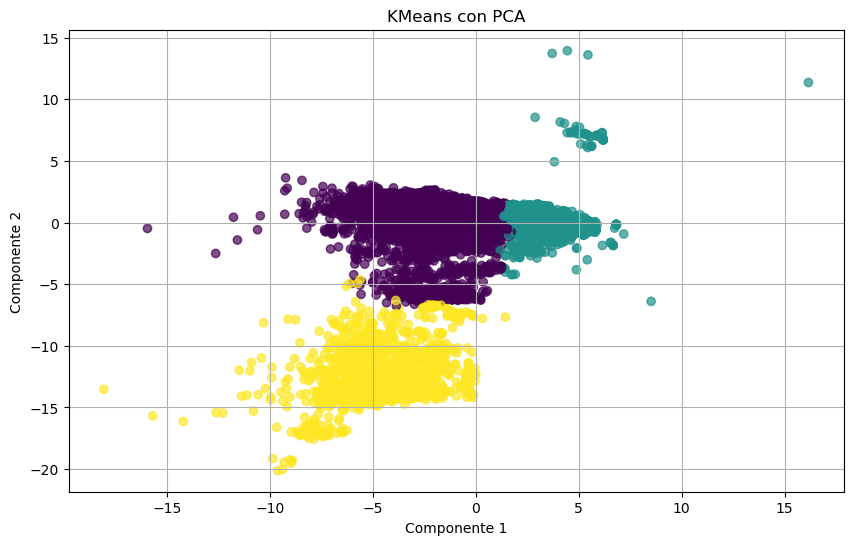

Bisecting KMeans (k=3) - Índice Silhouette: 0.3526


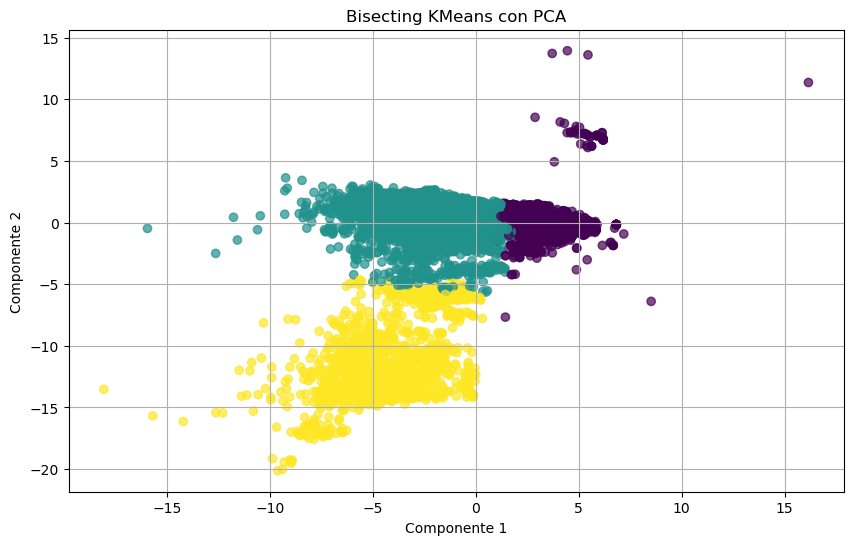

Gaussian Mixture (k=3) - Índice Silhouette: 0.0772


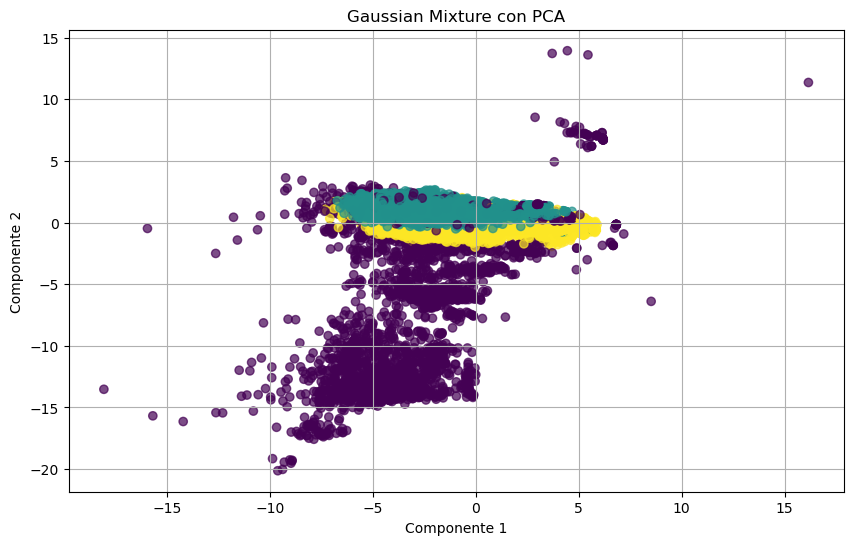

In [81]:
# Agrupamientos
k = 3
clustering_models = {
    "KMeans": KMeans(k=k, featuresCol='features', maxIter=10),
    "Bisecting KMeans": BisectingKMeans(k=k, featuresCol='features',
        maxIter=10),
    "Gaussian Mixture": GaussianMixture(k=k, featuresCol='features')
}

results = {}
for name, model in clustering_models.items():
    silhouette = evaluate_clustering(model.fit(df_features), df_features,
        feature_columns, k, method_name=name)
    results[name] = silhouette


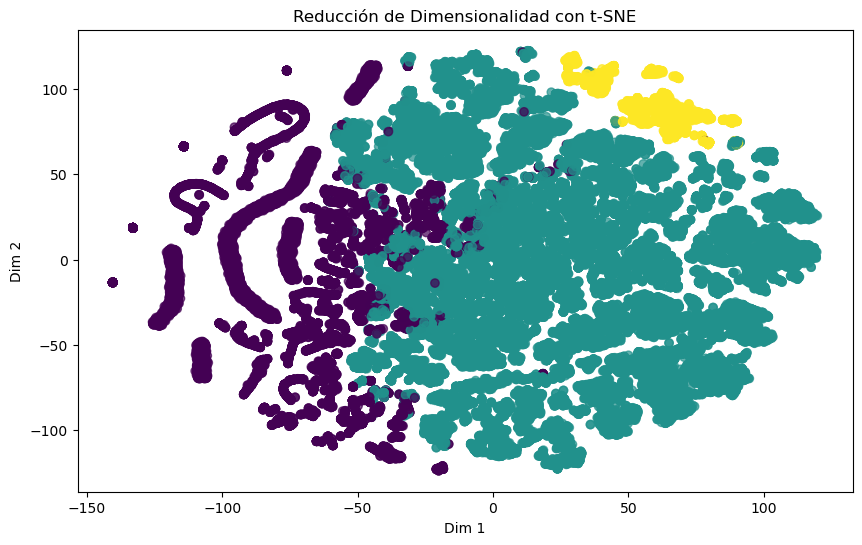

In [44]:
# Reducción de dimensionalidad con t-SNE
tsne_data = df_features.select(*feature_columns).toPandas()
tsne_result = TSNE(n_components=2, random_state=42).fit_transform(tsne_data)
plot_results(tsne_result, cluster_labels,
    "Reducción de Dimensionalidad con t-SNE", "Dim 1", "Dim 2")

In [ ]:
# Agrupamiento jerárquico
scaled_features = StandardScaler().fit_transform(
    df_features.select(*feature_columns).toPandas().values)
agg_labels = AgglomerativeClustering(n_clusters=k).fit_predict(scaled_features)
agg_silhouette = silhouette_score(scaled_features, agg_labels)
results["Agglomerative Clustering"] = agg_silhouette
print(f"Agglomerative Clustering - Índice Silhouette: {agg_silhouette:.2f}")

In [ ]:
# Comparar los resultados
print("\nComparación de índices Silhouette:")
for model, score in results.items():
    print(f"{model}: {score:.4f}")


Comparación de índices Silhouette:
K medias bisectantes: 0.353
K medias: 0.351
Gaussian Mixture: 0.077
Agrupamiento jerárquico: 0.348


In [ ]:
# Determinar el mejor número de grupos
def find_optimal_k(df_features, k_values):
    silhouette_scores = {}
    for k in k_values:
        model = BisectingKMeans(k=k, featuresCol='features', maxIter=10)
        predictions = model.fit(df_features).transform(df_features)
        df_pandas = predictions.select('features', 'prediction').toPandas()
        silhouette = silhouette_score(np.array(df_pandas['features'].tolist()),
            df_pandas['prediction'])
        silhouette_scores[k] = silhouette
        print(f"k={k}, Índice Silhouette: {silhouette:.2f}")
    return silhouette_scores

k_values = range(2, 11)
silhouette_scores = find_optimal_k(df_features, k_values)

In [ ]:
# Ver el k óptimo
optimal_k = max(silhouette_scores, key=silhouette_scores.get)
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()),
    marker='o')
plt.title("Índice Silhouette para diferentes valores de k")
plt.xlabel("Número de grupos (k)")
plt.ylabel("Índice Silhouette")
plt.grid()
plt.show()
print(f"Mejor número de grupos: {optimal_k}, " +
    "Índice Silhouette: {silhouette_scores[optimal_k]:.2f}")

In [66]:
# Rango de valores de k a explorar
k_values = range(2, 11)

# Resultados
silhouette_scores = {}

# Ciclo para evaluar diferentes valores de k
for k in k_values:
    # Configurar y ajustar el modelo de k medias
    kmeans = BisectingKMeans(k=k, featuresCol='features', maxIter=10)
    kmeans_model = kmeans.fit(df_features)

    # Realizar predicciones
    kmeans_predictions = kmeans_model.transform(df_features)

    # Convertir a Pandas para calcular el índice Silhouette
    df_pandas = kmeans_predictions.select('features', 'prediction').toPandas()
    features_list = df_pandas['features'].tolist()

    # Calcular el índice Silhouette
    score = silhouette_score(features_list, df_pandas['prediction'])
    silhouette_scores[k] = score
    print(f"k={k}, índice Silhouette: {score:.5f}")

k=2, índice Silhouette: 0.31858
k=3, índice Silhouette: 0.35256
k=4, índice Silhouette: 0.27304
k=5, índice Silhouette: 0.20641
k=6, índice Silhouette: 0.21043
k=7, índice Silhouette: 0.23185
k=8, índice Silhouette: 0.24210
k=9, índice Silhouette: 0.24362
k=10, índice Silhouette: 0.22158


In [67]:
# Determinar el mejor número de grupos
optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print("\nMejor número de grupos:", optimal_k)
print("Mejor índice Silhouette:", silhouette_scores[optimal_k])


Mejor número de grupos: 3
Mejor índice Silhouette: 0.3525572810552284


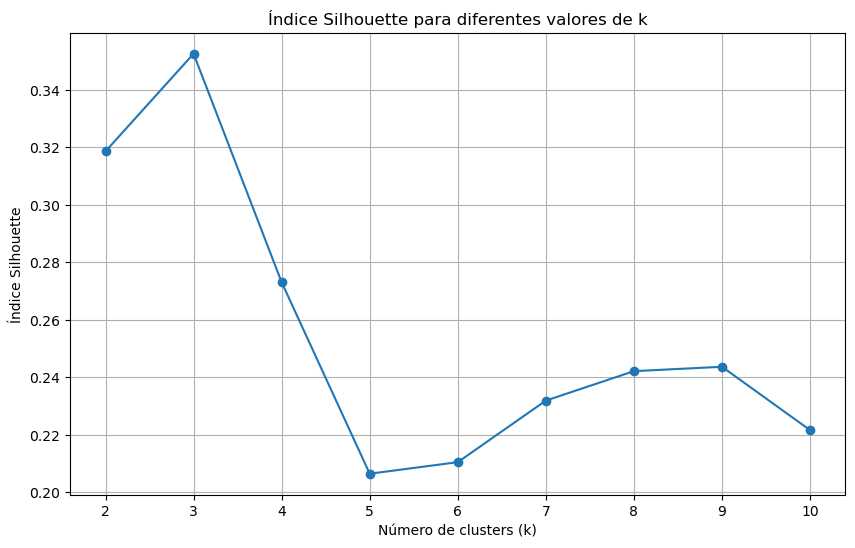

In [68]:
# Ver los resultados
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()),
    marker='o')
plt.title("Índice Silhouette para diferentes valores de k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Índice Silhouette")
plt.grid()
plt.show()